In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from matplotlib.colors import LogNorm

%matplotlib inline

# Multivariate Gaussian

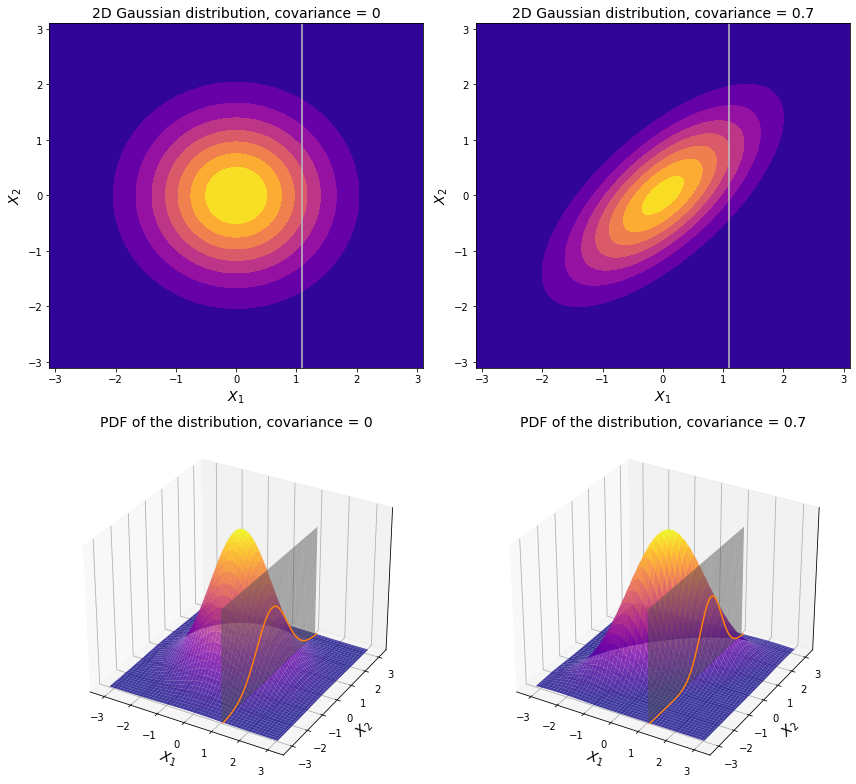

In [124]:
def plot_pdf(fig, subplot, X1, X2, cov):
    
    # 2X2 covariance matrix for the bivariate Gaussian distribution
    cov_matrix = np.array([[1, cov], [cov, 1]])
    distr = multivariate_normal(cov=cov_matrix, mean=[0, 0], seed=12345)
    # generate PDF of the multivariate Gaussian distribution
    pdf = np.zeros(X1.shape)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            pdf[i,j] = distr.pdf([X1[i,j], X2[i,j]])    
    
    ax_contour = fig.add_subplot(subplot)
    ax_contour.contourf(X1, X2, pdf, cmap='plasma')
    ax_contour.plot([1.1, 1.1], [-3.1, 3.1], color='silver')
    ax_contour.set_title(f'2D Gaussian distribution, covariance = {cov}', fontsize=14)
    ax_contour.set_xlabel(R'$X_1$', fontsize=14)
    ax_contour.set_ylabel(R'$X_2$', fontsize=14)
    
    
    ax_pdf = fig.add_subplot(subplot+2, projection = '3d')
    ax_pdf.plot_surface(X1, X2, pdf, cmap='plasma', alpha=0.8, zorder=0)
    
    # create plane
    x1_cut = 1.1
    x2_p = np.linspace(-3.1, 3.1, 100)
    z_p = np.linspace(0, pdf.max()*0.8, 100)
    X2_p, Z_p = np.meshgrid(x2_p, z_p)
    # plot plane
    ax_pdf.plot_surface(x1_cut, X2_p, Z_p, color='silver', alpha=0.5, zorder=5)
                    
    ax_pdf.set_xlabel(R'$X_1$', fontsize=14)
    ax_pdf.set_ylabel(R'$X_2$', fontsize=14)
    ax_pdf.set_title(f'PDF of the distribution, covariance = {cov}', fontsize=14)
    ax_pdf.axes.zaxis.set_ticks([])
    
    # find the closest idx values of X mesh to x1_cut
    tol = 1e-4
    idx_x_p = (np.where(x < x1_cut+tol) and np.where(x > x1_cut-tol))[0][0]
    # Select the corresponding values of X, Y, Z (carefully switch X and Y)
    x1_c, x2_c, z_c = X2[idx_x_p], X1[idx_x_p], pdf[idx_x_p]
    # plot line
    ax_pdf.plot(x1_c, x2_c, z_c, zorder=10)

fig = plt.figure(figsize=(12, 11))

X1, X2 = np.meshgrid(np.linspace(-3.1, 3.1, num=100),
                     np.linspace(-3.1, 3.1, num=100))

plot_pdf(fig, 221, X1, X2, cov=0)
plot_pdf(fig, 222, X1, X2, cov=0.7)

plt.tight_layout()
plt.savefig('../../assets/images/distributions/2d_gaussian_distribution.png', bbox_inches='tight');

# Covariance of the points

In [14]:
class SquaredExponentialKernel:
    def __init__(self, sigma_f: float = 1, length: float = 1):
        self.sigma_f = sigma_f
        self.length = length

    def __call__(self, argument_1: np.array, argument_2: np.array) -> float:
        return float(self.sigma_f *
                     np.exp(-(np.linalg.norm(argument_1 - argument_2)**2) /
                            (2 * self.length**2)))

def get_cov_matrix(x1, x2, cov_function) -> np.array:
    return np.array([[cov_function(a, b) for a in x1] for b in x2])

In [26]:
x = np.linspace(0, 10, 21)
cov_matrix = get_cov_matrix(x, x, SquaredExponentialKernel())

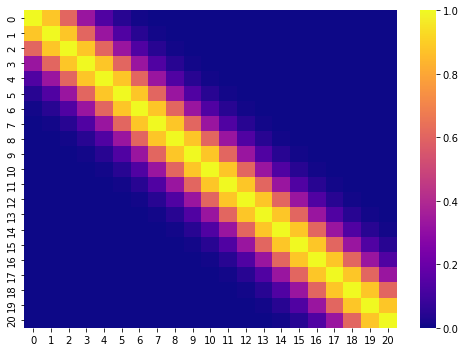

In [27]:
plt.figure(figsize=(7,5))
sns.heatmap(cov_matrix, cmap='plasma')
plt.tight_layout()
plt.savefig('../../assets/images/regression/covariance.png', bbox_inches='tight');

# Prediction using Gaussian process

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern, ExpSineSquared, DotProduct

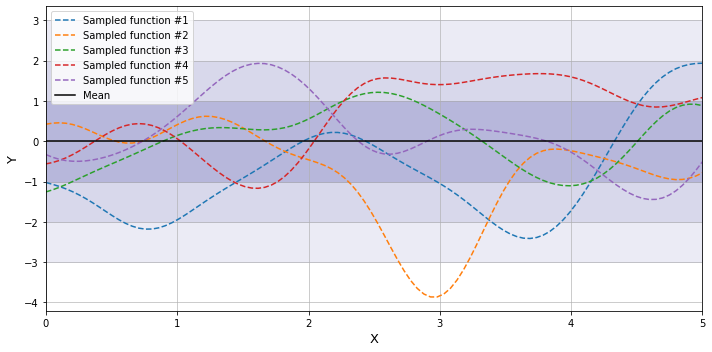

In [21]:
kernel = ConstantKernel() * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e3))
gpr_model = GaussianProcessRegressor(kernel=kernel, random_state=43)

x = np.linspace(0, 5, 100)
X = x.reshape(-1, 1)

y_samples = gpr_model.sample_y(X, 5)
y_mean, y_std = gpr_model.predict(X, return_std=True)

fig, ax = plt.subplots(figsize=(10, 5))
for idx, single_prior in enumerate(y_samples.T):
    ax.plot(
        x,
        single_prior,
        linestyle="--",
        label=f"Sampled function #{idx + 1}",
    )
ax.plot(x, y_mean, color="black", label="Mean")
ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.15,
        color="navy",
    )
ax.fill_between(
    x,
    y_mean - 2*y_std,
    y_mean + 2*y_std,
    alpha=0.08,
    color="navy",
)
ax.fill_between(
    x,
    y_mean - 3*y_std,
    y_mean + 3*y_std,
    alpha=0.08,
    color="navy"
)
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_ylim([-3.2, 3.2])
ax.set_xlim(x.min(), x.max())

plt.grid(alpha=0.8)
plt.legend()
ax.set_xlabel('X', fontsize=13)
ax.set_ylabel('Y', fontsize=13)
plt.tight_layout()
plt.savefig(f'../../assets/images/regression/gp_priors_example.png', bbox_inches='tight')

In [3]:
def plot_posterior(X_train, y_train, x, kernel, png_name = None):
    '''If png_name is provided then the image is saved in the regression folder'''
    
    def true_func(x):
        return np.sin((x - 2.5) ** 2)
    
    X = x.reshape(-1, 1)
    gpr_model = GaussianProcessRegressor(kernel=kernel, random_state=0)
    gpr_model.fit(X_train, y_train)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim(x.min(), x.max())
    ax.scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
    ax.plot(x, y_mean, color='navy', label='Gaussian process mean')
    ax.plot(x, true_func(x), color="black", label='True function', linestyle='--')
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.2,
        color="navy",
    )
    ax.fill_between(
        x,
        y_mean - 2*y_std,
        y_mean + 2*y_std,
        alpha=0.1,
        color="navy",
    )
    ax.fill_between(
        x,
        y_mean - 3*y_std,
        y_mean + 3*y_std,
        alpha=0.1,
        color="navy"
    )
    ax.set_xlabel('X', fontsize=13)
    ax.set_ylabel('Y', fontsize=13)
    
    plt.legend()
    plt.grid(alpha=0.8)
    plt.tight_layout()
    
    print(f"Initial: {kernel}\nOptimum: {gpr_model.kernel_}\nLog-Marginal-Likelihood: " \
    f"{gpr_model.log_marginal_likelihood(gpr_model.kernel_.theta)}")
    
    if png_name:
        plt.savefig(f'../../assets/images/regression/{png_name}.png', bbox_inches='tight')
        
    return gpr_model

Run for a random initial values, then inspect the log-likelihood contour plot, and select better intial values for the parameters

Initial: 1**2 * RBF(length_scale=0.5) + WhiteKernel(noise_level=0.001)
Optimum: 1.36**2 * RBF(length_scale=0.292) + WhiteKernel(noise_level=0.271)
Log-Marginal-Likelihood: -17.98455306904024


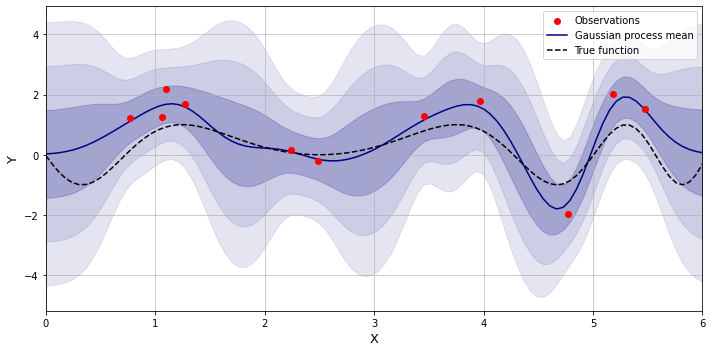

In [4]:
rng = np.random.RandomState(355)
X_train = rng.uniform(0, 5.5, 11).reshape(-1, 1)
y_train = 2*np.sin((X_train[:, 0] - 2.5) ** 2) + rng.normal(0, 0.3, size=X_train[:, 0].shape)

# all space of X
x = np.linspace(0, 6, 100)

kernel = ConstantKernel() * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=0.001, noise_level_bounds=(1e-5, 1e1)
)
gpr_model = plot_posterior(X_train, y_train, x, kernel, png_name='gp_rbf_fit_example')

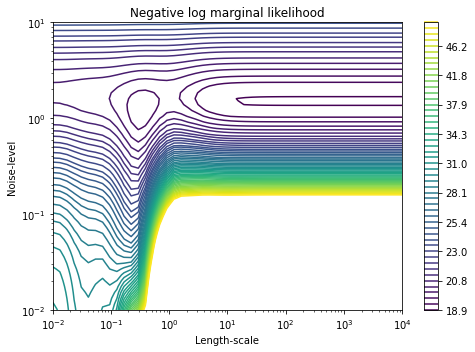

In [26]:
y_train_mean = np.mean(y_train)

length_scale = np.logspace(-2, 4, num=50)
noise_level = np.logspace(-2, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr_model.log_marginal_likelihood(theta=np.log([0.5, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)
vmin, vmax = (-log_marginal_likelihood).min(), 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)

fig, ax = plt.subplots(figsize=(7, 5))
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Negative log marginal likelihood")
plt.tight_layout()
plt.savefig('../../assets/images/optimization/gp_contour_log_marginal_likelihood.png', bbox_inches='tight')

In [29]:
np.log(2*np.pi)/2

0.9189385332046727

## Overview of different kernels

## Matern kernel

Initial: 1**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.001)
Optimum: 1.36**2 * Matern(length_scale=0.325, nu=1.5) + WhiteKernel(noise_level=0.275)
Log-Marginal-Likelihood: -18.305395549059305


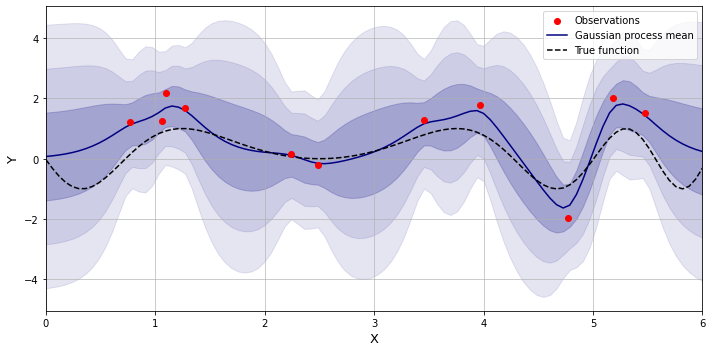

In [184]:
rng = np.random.RandomState(355)
X_train = rng.uniform(0, 5.5, 11).reshape(-1, 1)
y_train = 2*np.sin((X_train[:, 0] - 2.5) ** 2) + rng.normal(0, 0.3, size=X_train[:, 0].shape)

# all space of X
x = np.linspace(0, 6, 100)

kernel = ConstantKernel() * Matern(length_scale=0.5, length_scale_bounds=(1e-2, 1e3), nu=1.5) + WhiteKernel(
    noise_level=0.001, noise_level_bounds=(1e-5, 1e1)
) 
gpr_model = plot_posterior(X_train, y_train, x, kernel, 'gp_matern_example')

## Periodic kernel

Initial: 1**2 * ExpSineSquared(length_scale=0.9, periodicity=2.3) + WhiteKernel(noise_level=0.001)
Optimum: 1.22**2 * ExpSineSquared(length_scale=0.9, periodicity=2.3) + WhiteKernel(noise_level=0.537)
Log-Marginal-Likelihood: -16.568597251651973


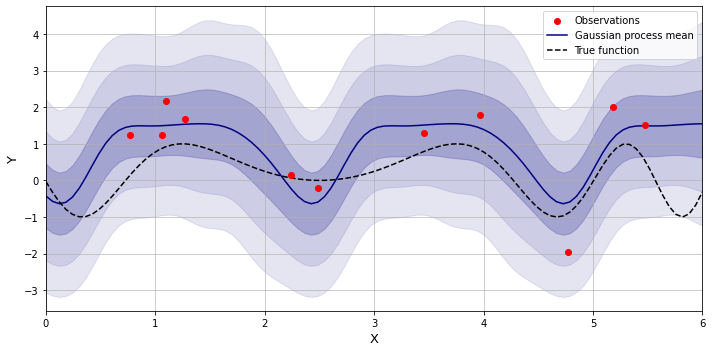

In [318]:
rng = np.random.RandomState(355)
X_train = rng.uniform(0, 5.5, 11).reshape(-1, 1)
y_train = 2*np.sin((X_train[:, 0] - 2.5) ** 2) + rng.normal(0, 0.3, size=X_train[:, 0].shape)

# all space of X
x = np.linspace(0, 6, 100)

kernel = ConstantKernel() * ExpSineSquared(0.9, 2.3, 'fixed', 'fixed') \
+ WhiteKernel(noise_level=0.001, noise_level_bounds=(1e-5, 1e1))
gpr_model = plot_posterior(X_train, y_train, x, kernel, 'gp_periodic_example')

Initial: 1**2 * ExpSineSquared(length_scale=0.9, periodicity=2.3) * RBF(length_scale=1.7) + WhiteKernel(noise_level=0.001)
Optimum: 1.36**2 * ExpSineSquared(length_scale=0.9, periodicity=2.3) * RBF(length_scale=1.7) + WhiteKernel(noise_level=0.299)
Log-Marginal-Likelihood: -17.641035396513466


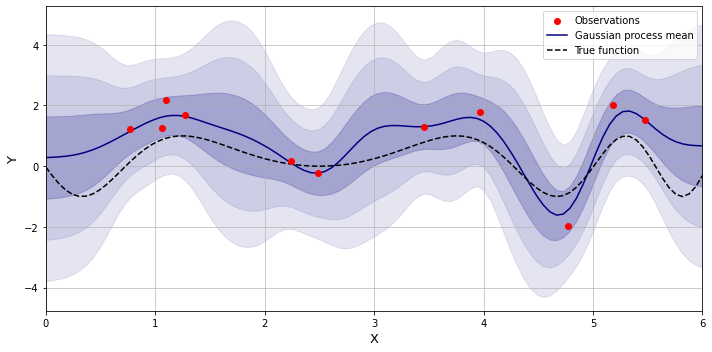

In [371]:
rng = np.random.RandomState(355)
X_train = rng.uniform(0, 5.5, 11).reshape(-1, 1)
y_train = 2*np.sin((X_train[:, 0] - 2.5) ** 2) + rng.normal(0, 0.3, size=X_train[:, 0].shape)

# all space of X
x = np.linspace(0, 6, 100)

kernel = ConstantKernel() * ExpSineSquared(0.9, 2.3, 'fixed', 'fixed') * RBF(1.7, 'fixed') \
+ WhiteKernel(noise_level=0.001) 
gpr_model = plot_posterior(X_train, y_train, x, kernel, 'gp_periodic_and_rbf_example')

## Linear kernel

In [401]:
def plot_posterior(X_train, true_func, x, kernel, png_name = None):
    '''If png_name is provided then the image is saved in the regression folder'''
    
    y_train = true_func(X_train[:, 0]) + rng.normal(0, 0.3, size=X_train[:, 0].shape)
    
    X = x.reshape(-1, 1)
    gpr_model = GaussianProcessRegressor(kernel=kernel, random_state=0)
    gpr_model.fit(X_train, y_train)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim(x.min(), x.max())
    ax.scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
    ax.plot(x, y_mean, color='navy', label='Gaussian process mean')
    ax.plot(x, true_func(x), color="black", label='True function', linestyle='--')
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.2,
        color="navy",
    )
    ax.fill_between(
        x,
        y_mean - 2*y_std,
        y_mean + 2*y_std,
        alpha=0.1,
        color="navy",
    )
    ax.fill_between(
        x,
        y_mean - 3*y_std,
        y_mean + 3*y_std,
        alpha=0.1,
        color="navy"
    )
    ax.set_xlabel('X', fontsize=13)
    ax.set_ylabel('Y', fontsize=13)
    
    plt.legend()
    plt.grid(alpha=0.8)
    plt.tight_layout()
    
    print(f"Initial: {kernel}\nOptimum: {gpr_model.kernel_}\nLog-Marginal-Likelihood: " \
    f"{gpr_model.log_marginal_likelihood(gpr_model.kernel_.theta)}")
    
    if png_name:
        plt.savefig(f'../../assets/images/regression/{png_name}.png', bbox_inches='tight')
        
    return gpr_model

Initial: DotProduct(sigma_0=1) + 1**2 * ExpSineSquared(length_scale=0.7, periodicity=3.2) + WhiteKernel(noise_level=0.001)
Optimum: DotProduct(sigma_0=0.000183) + 0.718**2 * ExpSineSquared(length_scale=0.000107, periodicity=8.8e+03) + WhiteKernel(noise_level=0.187)
Log-Marginal-Likelihood: -19.59496918454976


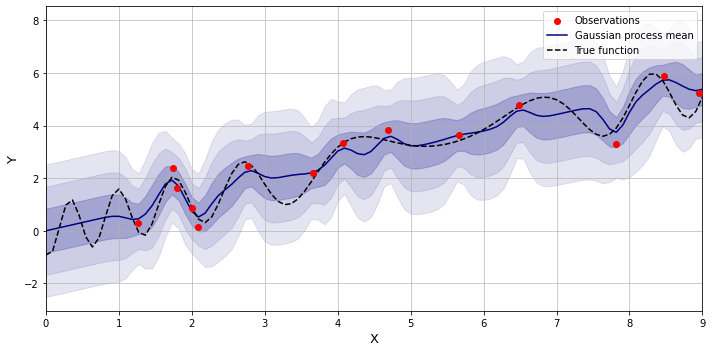

In [444]:
rng = np.random.RandomState(355)
X_train = rng.uniform(0, 9, 14).reshape(-1, 1)

def true_func(x):
    return np.sin((x - 5.5) ** 2)+0.6*x

# all space of X
x = np.linspace(0, 9, 100)

kernel = DotProduct(1) + ConstantKernel() * ExpSineSquared(0.7, 3.2) + WhiteKernel(noise_level=0.001) 
gpr_model = plot_posterior(X_train, true_func, x, kernel, 'gp_periodic_and_linear_example')

Initial: DotProduct(sigma_0=0.3) * 1**2 * ExpSineSquared(length_scale=1.7, periodicity=4) + WhiteKernel(noise_level=0.001)
Optimum: DotProduct(sigma_0=0.0512) * 0.413**2 * ExpSineSquared(length_scale=1.3e-05, periodicity=7.19e+04) + WhiteKernel(noise_level=0.186)
Log-Marginal-Likelihood: -25.87024137569278


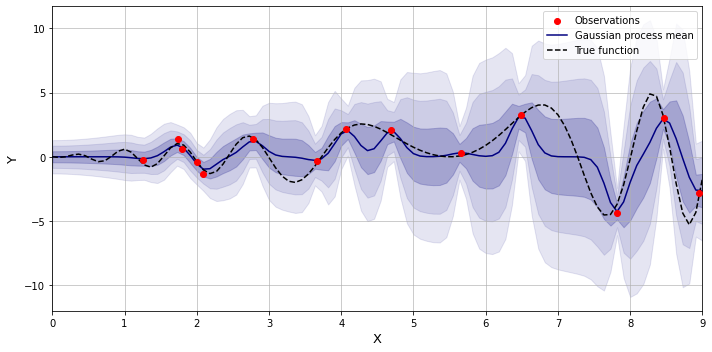

In [479]:
rng = np.random.RandomState(355)
X_train = rng.uniform(0, 9, 14).reshape(-1, 1)

def true_func(x):
    return np.sin((x - 5.5) ** 2)*0.6*x

# all space of X
x = np.linspace(0, 9, 100)

kernel = DotProduct(0.3) * ConstantKernel() * ExpSineSquared(1.7, 4, (1e-05, 100000), ) + WhiteKernel(noise_level=0.001) 
gpr_model = plot_posterior(X_train, true_func, x, kernel, 'gp_periodic_times_linear_example')